In [20]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

In [21]:
df_demandas = pd.read_csv('../Resultados/tabelas/Demandas_treinamento/demandas',
                          index_col='date',
                          parse_dates=True)['demandas']

In [22]:
'''
order(
      p = defini a ordem do polinômio autorregressivo,
      d = defini a ordem do operador de diferença simples,
      q = defini a ordem do polinômio média móvel simples
      )
      
seasonal_order(
               P = defini a ordem do polinômio autorregressivo sazonal,
               D = defini a ordem do operador de diferença sazonal,
               Q = defini a ordem do polinômio média móvel sazonal,
               s = é um inteiro que dá a periodicidade (número de períodos na temporada)
               )
'''
#nosso s seria 52

params={
    'freq':'7d',
    #'tren':'ct',
    'order':(0,0,0),
    #'seasonal_order':(0,1,1,52),
    #'order':(5,0,3),
    'seasonal_order':(0,1,1,52),
}

In [23]:
df_train, df_test = df_demandas.iloc[:166],df_demandas.iloc[166:]

In [24]:
model=sm.tsa.statespace.SARIMAX(df_train,**params)
results=model.fit()

c:\Users\marci\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
c:\Users\marci\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [25]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                   demandas   No. Observations:                  166
Model:             SARIMAX(0, 1, [1], 52)   Log Likelihood                -200.575
Date:                    Thu, 19 Oct 2023   AIC                            405.150
Time:                            15:34:44   BIC                            410.622
Sample:                        01-01-2015   HQIC                           407.371
                             - 03-01-2018                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -0.8198      0.756     -1.084      0.278      -2.302       0.662
sigma2         1.3849      0.985      1.405      0.160      -0.547       3.316
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.41   Prob(JB):                         0.62
Heteroskedasticity (H):               0.76   Skew:                             0.10
Prob(H) (two-sided):                  0.40   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
forecast = results.get_forecast(len(df_test))

In [27]:
previsao_test = forecast.predicted_mean

In [28]:
interval = forecast.conf_int() 

In [29]:
round(len(previsao_test)/len(df_demandas),4)

0.2057

In [30]:
'''
with open("../Resultados/tabelas/Prev_teste/test_sarima.txt", "w") as arquivo:
    n = len(previsao_test)
    for j in range(n-1):
        arquivo.write(f'{previsao_test.values[j]}, ')
    arquivo.write(f'{previsao_test.values[n-1]}')
'''

'\nwith open("../Resultados/tabelas/Prev_teste/test_sarima.txt", "w") as arquivo:\n    n = len(previsao_test)\n    for j in range(n-1):\n        arquivo.write(f\'{previsao_test.values[j]}, \')\n    arquivo.write(f\'{previsao_test.values[n-1]}\')\n'

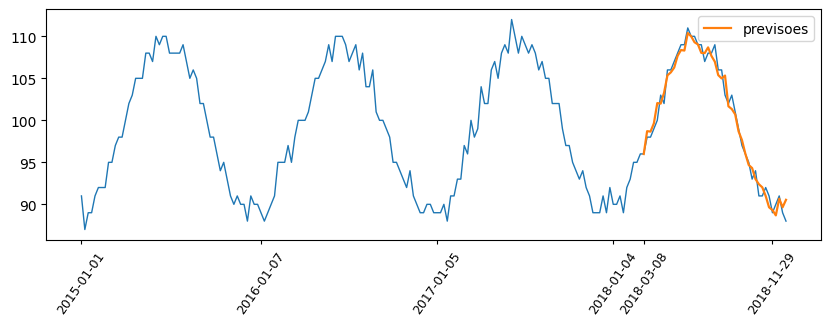

In [31]:
fig=plt.figure(figsize=(10,3))

ax=fig.add_subplot(1,1,1)

plt.plot(df_demandas.index,df_demandas, linewidth=1)
plt.plot(previsao_test.index,previsao_test,label='previsoes', linewidth=1.6)
plt.xticks([df_demandas.index[i] for i in [0,53,105,157,166,204]])
plt.tick_params(axis='x', labelsize=9, length=3)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.legend()


In [32]:
residuos = np.array(df_test)-np.array(previsao_test)

$e_{i} = y_{i}-\hat{y}_{i}\sim N\left(0,30\right)$

In [33]:
import seaborn as sns

In [34]:
normal = np.random.normal(0, 1,2000000)

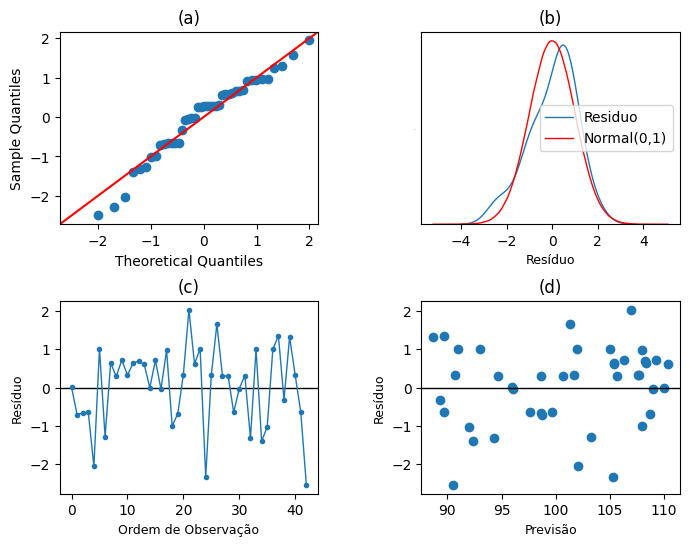

In [35]:
fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
titulo = ['(a)','(b)','(c)','(d)']

ax=fig.add_subplot(2,2,3)
ax.set_title(titulo[2])
plt. axhline(y=0,xmin=0,xmax=len(previsao_test),color='black', linewidth=1)
plt.plot(range(len(residuos)),residuos,marker='.', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Ordem de Observação',fontsize=9)

ax=fig.add_subplot(2,2,2)
ax.set_title(titulo[1])
sns.kdeplot(residuos,label="Residuo", linewidth=1)
sns.kdeplot(normal,label='Normal(0,1)', linewidth=1,color='red')
plt.legend()
#plt.tick_params(axis='y', labelsize=0, length=0)
plt.yticks([])
plt.ylabel([], fontsize=0)
plt.xlabel('Resíduo',fontsize=9)

ax=fig.add_subplot(2,2,1)
ax.set_title(titulo[0])
sm.qqplot(residuos,fit=True,line='45',ax=ax)

ax=fig.add_subplot(2,2,4)
ax.set_title(titulo[3])
plt.scatter(previsao_test,residuos)
plt.axhline(y=0,xmin=0,xmax=len(previsao_test),color='black', linewidth=1)
plt.ylabel('Resíduo',fontsize=9)
plt.xlabel('Previsão',fontsize=9)

plt.savefig('../Resultados/img/Sarima_Residuos.png', bbox_inches='tight',pad_inches = 0.1,format='png')
plt.show()

In [36]:
import statsmodels.api as sm

#print('MSE_Teste =',sm.tools.eval_measures.mse(previsoes_test, df_test.y, axis=0))

print('RMSE_Teste =',round(sm.tools.eval_measures.rmse(previsao_test, df_test, axis=0),4))

print('MAE_Teste =',round(sm.tools.eval_measures.meanabs(previsao_test, df_test, axis=0),4))

print(f'MAPE_Teste = {round(100*metrics.mean_absolute_percentage_error(df_test, previsao_test),4)}%')

RMSE_Teste = 1.0286
MAE_Teste = 0.8335
MAPE_Teste = 0.8409%


MAE = $\frac{1}{n}\sum_{i=1}^{n}\mid y_{i}-\hat{y}\mid$ 

RMSE = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(y_{i}-\hat{y}\right)^{2}}$

MAPE = $\frac{1}{n}\sum_{i=1}^{n}\mid \frac{y_{i}-\hat{y}}{y_{i}}\mid$ 

In [37]:
from statsmodels.stats.diagnostic import acorr_ljungbox
jlung = acorr_ljungbox(residuos,lags=42)

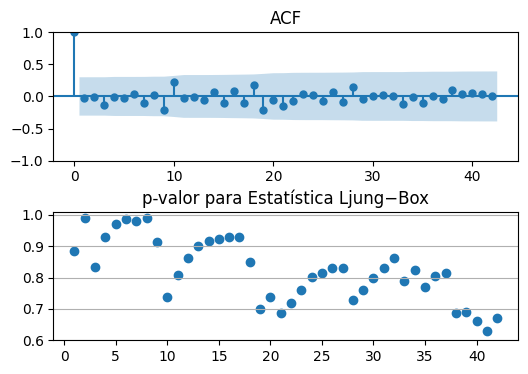

In [38]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig=plt.figure(figsize=(6,4))
plt.subplots_adjust(wspace=0, hspace=0.4)


ax=fig.add_subplot(2,1,1)
plot_acf(residuos,title='ACF',lags=42,alpha=.05,ax=ax)

ax=fig.add_subplot(2,1,2)
plt.title('p-valor para Estatística Ljung−Box')
plt.scatter(range(1,43),jlung[jlung.columns[1]],marker='o')
plt.xticks([5*i for i in range(9)])
plt.yticks([0.6,0.7,0.8,0.9,1])
plt.grid(axis='y')

plt.savefig('../Resultados/img/Residuo_ACF_Ljung_Box_sar.png', bbox_inches='tight',pad_inches = 0.1,format='png')

plt.show()

# Fase de Previsão

In [39]:
qtd_previsoes = 17

In [40]:

for i in range(60):
        
    model = sm.tsa.arima.ARIMA(df_demandas,**params)
    results = model.fit()
    forecast = results.get_forecast(qtd_previsoes)
    previsao = forecast.predicted_mean
    interval = forecast.conf_int() 

    interval[['lower demandas','upper demandas']].to_csv(f'../Resultados/tabelas/Intervalos_Confianca/SA/IC_SA{i}')
    with open(f"../Resultados/tabelas/Previsoes/Prev_sar/Previsao_sar{i}.txt", "w") as arquivo:
        n = len(previsao)
        for j in range(n-1):
            arquivo.write(f'{previsao[j]}, ')
        arquivo.write(f'{previsao[n-1]}')


c:\Users\marci\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-THU will be used.
  self._init_dates(dates, freq)
c:\Users\marci\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\marci\AppData\Local\Temp\ipykernel_11492\991419684.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  arquivo.write(f'{previsao[j]}, ')
C:\Users\marci\AppData\Local\Temp\ipykernel_11492\991419684.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future 